In [1]:
import pandas as pd
import numpy as np
import pyModeS as pyms
import matplotlib.pyplot as plt

pd.set_option("display.float_format", lambda x: "%.8f" % x)
%load_ext lab_black
%load_ext nb_black

# Load sample data

In [2]:
data = pd.read_csv("data/samples.csv", names=["timestamp", "message"])

# infer the ICAO address
data["icao"] = data.message.apply(pyms.icao)

# Compute the Downlink Format
data["DF"] = data.message.apply(pyms.df)

## Now we can filter out the Comm-B data with Downlink Format 20 and 21
Recall that:
- DF=20 is the altitude reply, 
- DF=21 is the identity reply

In [3]:
commb = data[data.DF.isin([20, 21])].copy()
print(commb.head(20))

              timestamp                       message    icao  DF
148 1568017744.52123499  A8001E2520053332C1A820363386  4C01E4  21
160 1568017745.13461709  A000011110010080F9000067FDC6  4C01E4  20
161 1568017745.15711856  A8001E25FA8101000000002B2022  4C01E4  21
162 1568017745.17500615  A000011120053332C1A82079E192  4C01E4  20
164 1568017745.19882560  A8001E253000000000000037186E  4C01E4  21
165 1568017745.21270871  A00001118BB80030CC0000BF2A76  4C01E4  20
167 1568017745.23580289  A8001E2580B81912A0344BF8DA20  4C01E4  21
168 1568017745.25928330  A0000111C2592D0E628C5059FB48  4C01E4  20
185 1568017746.18452120  A00001138BB80030CC0000429E32  4C01E4  20
188 1568017746.40723252  A000011380B81B12A0344B4CA9EC  4C01E4  20
189 1568017746.51494360  A000011320053332C1A8208455D6  4C01E4  20
213 1568017749.05096769  A0000118300000000000000F295A  4C01E4  20
225 1568017750.56483150  A000011BC2692B0E6294503E4B1B  4C01E4  20
239 1568017752.39558363  A8001E2520053332C1A820363386  4C01E4  21
257 156801

## We can decode the **altitude** for DF=20 messages, and **squawk code** for DF=21 messages

In [4]:
commb["altitude"] = None
commb["squawk"] = None

commb.loc[commb.DF == 20, "altitude"] = commb.loc[commb.DF == 20, "message"].apply(
    pyms.common.altcode
)

commb.loc[commb.DF == 21, "squawk"] = commb.loc[commb.DF == 21, "message"].apply(
    pyms.common.idcode
)

## Display the altitude profile from DF=20 data

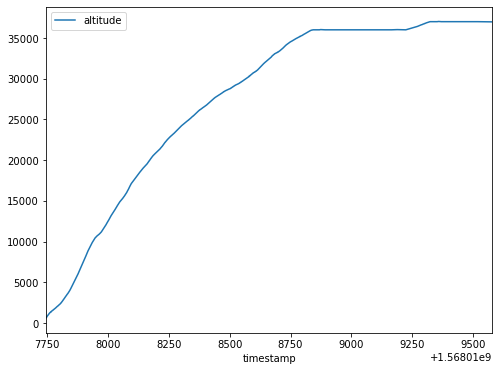

In [5]:
commb[commb.DF == 20].plot(x="timestamp", y="altitude", figsize=(8, 6))

## And the Squawk code?

In [6]:
commb[commb.DF == 21].squawk.unique().tolist()

['3136']

---
# Advanced - Comm-B type inference

First we have to infer what is the type (BDS code) of each Comm-B message. Then we can decode them accordingly.

In [7]:
commb["BDS"] = commb.message.apply(pyms.bds.infer)
print(commb[["timestamp", "message", "BDS"]].head(20))

              timestamp                       message          BDS
148 1568017744.52123499  A8001E2520053332C1A820363386        BDS20
160 1568017745.13461709  A000011110010080F9000067FDC6        BDS10
161 1568017745.15711856  A8001E25FA8101000000002B2022        BDS17
162 1568017745.17500615  A000011120053332C1A82079E192        BDS20
164 1568017745.19882560  A8001E253000000000000037186E        BDS30
165 1568017745.21270871  A00001118BB80030CC0000BF2A76        BDS40
167 1568017745.23580289  A8001E2580B81912A0344BF8DA20  BDS50,BDS60
168 1568017745.25928330  A0000111C2592D0E628C5059FB48        BDS60
185 1568017746.18452120  A00001138BB80030CC0000429E32        BDS40
188 1568017746.40723252  A000011380B81B12A0344B4CA9EC  BDS50,BDS60
189 1568017746.51494360  A000011320053332C1A8208455D6        BDS20
213 1568017749.05096769  A0000118300000000000000F295A        BDS30
225 1568017750.56483150  A000011BC2692B0E6294503E4B1B        BDS60
239 1568017752.39558363  A8001E2520053332C1A820363386        B

## Statistic of Comm-B types
Recall:
 - BDS 1,0 - Data link capability
 - BDS 1,7 - GICB capability 
 - BDS 2,0 - Aircraft identification
 - BDS 3,0 - ACAS resolution
 - BDS 4,0 - Vertical intention report
 - BDS 5,0 - Track and turn report
 - BDS 6,0 - Heading and speed report


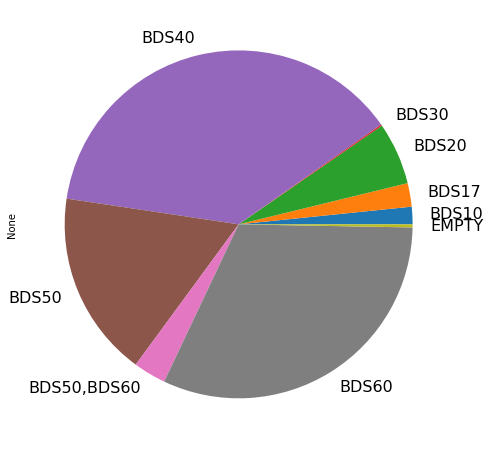

In [8]:
commb.groupby("BDS").size().plot(kind="pie", figsize=(8, 8), fontsize=16)

## How about these with BDS50,BDS60
BDS 5,0 and 6,0 shares similar structure. We can futher determine these two types, with reference speed from ADS-B.

In [9]:
adsb = data[data.DF == 17].copy()
adsb["TC"] = adsb.message.apply(pyms.typecode)

# get reference speed and track angle
velocity = adsb[adsb.TC == 19].copy()
velocity["spd"] = velocity.message.apply(lambda x: pyms.adsb.velocity(x)[0])
velocity["trk"] = velocity.message.apply(lambda x: pyms.adsb.velocity(x)[1])
velocity = velocity[["timestamp", "spd", "trk"]]

# get reference altitude
altitude = adsb[adsb.TC.between(5, 18)].copy()
altitude["alt"] = altitude.message.apply(pyms.adsb.altitude)
altitude = altitude[["timestamp", "alt"]]

# merger with closest reference speed and altitude
commb_ = pd.merge_asof(commb, velocity, on="timestamp")
commb_ = pd.merge_asof(commb_, altitude, on="timestamp")

## Additional BDS 50/60 inference

In [10]:
commb.loc[commb.BDS == "BDS50,BDS60", "BDS"] = commb_[
    commb_.BDS == "BDS50,BDS60"
].apply(lambda x: pyms.bds.is50or60(x.message, x.spd, x.trk, x.alt), axis=1)

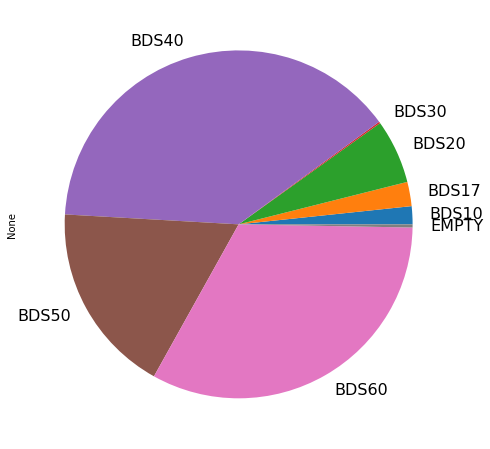

In [11]:
commb.groupby("BDS").size().plot(kind="pie", figsize=(8, 8), fontsize=16)

---
# Decoding Comm-B messages
## BDS40: Vertical intentions

In [33]:
bds40 = commb[commb.BDS == "BDS40"].copy()
bds40["selalt40fms"] = bds40.message.apply(pyms.commb.selalt40fms)
bds40["selalt40mcp"] = bds40.message.apply(pyms.commb.selalt40mcp)

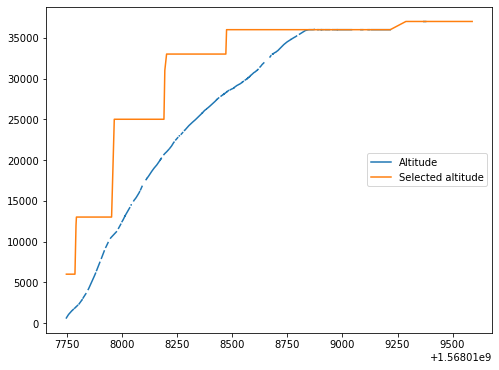

In [64]:
plt.figure(figsize=(8, 6))
plt.plot(bds40.timestamp, bds40.altitude, label="Altitude")
plt.plot(bds40.timestamp, bds40.selalt40mcp, label="Selected altitude")
plt.legend(loc=7)
plt.show()

## BDS 50: Track and turn report

In [46]:
bds50 = commb[commb.BDS == "BDS50"].copy()
bds50["roll"] = bds50.message.apply(pyms.commb.roll50)
bds50["track"] = bds50.message.apply(pyms.commb.trk50)
bds50["track_rate"] = bds50.message.apply(pyms.commb.rtrk50)
bds50["ground_speed"] = bds50.message.apply(pyms.commb.gs50)
bds50["true_airspeed"] = bds50.message.apply(pyms.commb.tas50)

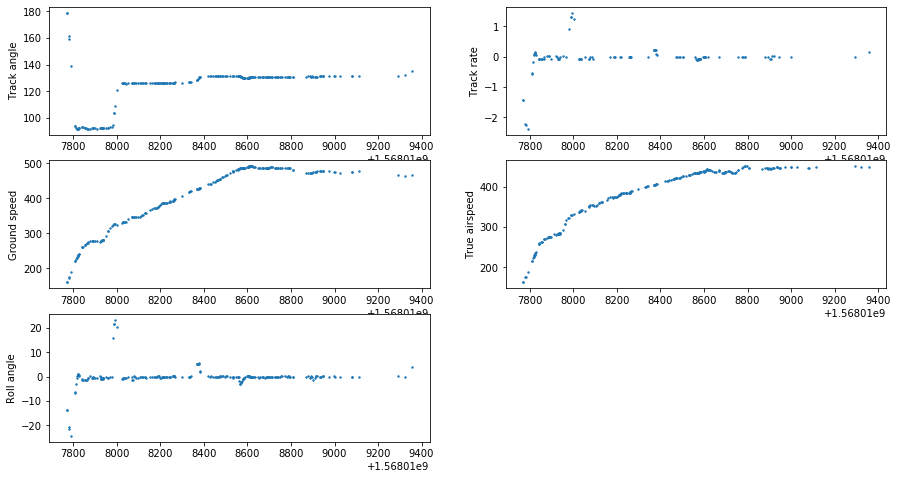

In [62]:
plt.figure(figsize=(15, 8))

plt.subplot(321)
plt.scatter(bds50.timestamp, bds50.track, s=2)
plt.ylabel("Track angle")

plt.subplot(322)
plt.scatter(bds50.timestamp, bds50.track_rate, s=2)
plt.ylabel("Track rate")

plt.subplot(323)
plt.scatter(bds50.timestamp, bds50.ground_speed, s=2)
plt.ylabel("Ground speed")

plt.subplot(324)
plt.scatter(bds50.timestamp, bds50.true_airspeed, s=2)
plt.ylabel("True airspeed")

plt.subplot(325)
plt.scatter(bds50.timestamp, bds50.roll, s=2)
plt.ylabel("Roll angle")


plt.show()

## BDS 60: Heading and speed report

In [56]:
bds60 = commb[commb.BDS == "BDS60"].copy()
bds60["heading"] = bds60.message.apply(pyms.commb.hdg60)
bds60["indicated_airspeed"] = bds60.message.apply(pyms.commb.ias60)
bds60["mach_number"] = bds60.message.apply(pyms.commb.mach60)
bds60["vertical_rate_ins"] = bds60.message.apply(pyms.commb.vr60ins)
bds60["vertical_rate_baro"] = bds60.message.apply(pyms.commb.vr60baro)

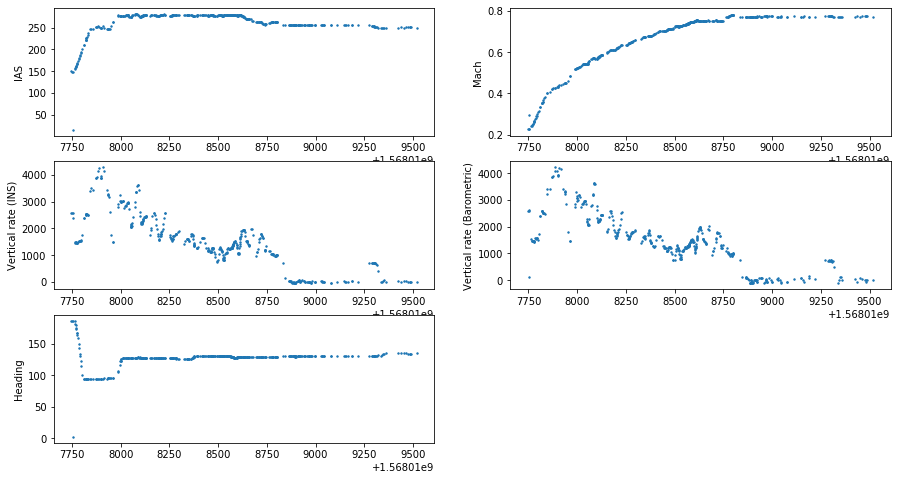

In [61]:
plt.figure(figsize=(15, 8))

plt.subplot(321)
plt.scatter(bds60.timestamp, bds60.indicated_airspeed, s=2)
plt.ylabel("IAS")

plt.subplot(322)
plt.scatter(bds60.timestamp, bds60.mach_number, s=2)
plt.ylabel("Mach")

plt.subplot(323)
plt.scatter(bds60.timestamp, bds60.vertical_rate_ins, s=2)
plt.ylabel("Vertical rate (INS)")

plt.subplot(324)
plt.scatter(bds60.timestamp, bds60.vertical_rate_baro, s=2)
plt.ylabel("Vertical rate (Barometric)")

plt.subplot(325)
plt.scatter(bds60.timestamp, bds60.heading, s=2)
plt.ylabel("Heading")

plt.show()